# **LeNet5 Model Implementation**

Note: Skip the 'Initialize model' part if not interested in retraining the model

### **Group Pogi**
*   Programmed the model
    *   Cabo, Elias Ezar
*   Researched the model (layer structure and trainable parameters)
    *   Cabo, Elias Ezar
    *   Villegas, Lex
*   Trained and tested the model
    *   Villegas, Lex
    *   Salibio, John Paul
*  Data Prerpocessing and Cleanup
    *   Sabarre, Christian
    *   Salibio, John Paul



In [1]:
import codecs
import os
import zipfile as zp
import requests
import shutil 
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt
import string
import random
import tensorflow as tf
import cv2 as cv
import pandas as pd

In [2]:
# Dataset Source: http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
base_dir = '/content/elec3_dataset'
zip_file = 'gzip.zip'
gzipFldr_path = os.path.join(base_dir, 'gzip')

try:
  os.mkdir(base_dir)
except:
  pass

### Fetch and unzip the EMNIST dataset using the link provided

In [3]:
url = 'http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip'
r = requests.get(url, allow_redirects=True)
opn_zipFile = open(os.path.join(base_dir, zip_file), 'wb')
opn_zipFile.write(r.content)

561753746

In [4]:
with zp.ZipFile(os.path.join(base_dir, zip_file), 'r') as zip_ref:
    zip_ref.extractall(base_dir)

### Define Functions

In [5]:
def read_idx(file):
  print('Processing data from %s.' % file)
  with gzip.open(file, 'rb') as f:
    z, dtype, dim = struct.unpack('>HBB', f.read(4))
    print('Dimensions: ', dim)
    shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dim))
    print("Shape: ", shape)
    return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [6]:
def load_mnist(dl_path):
  train_images = os.path.join(dl_path, 'emnist-letters-train-images-idx3-ubyte.gz')
  train_labels = os.path.join(dl_path, 'emnist-letters-train-labels-idx1-ubyte.gz')
  test_images = os.path.join(dl_path, 'emnist-letters-test-images-idx3-ubyte.gz')
  test_labels = os.path.join(dl_path, 'emnist-letters-test-labels-idx1-ubyte.gz')

  train_x = read_idx(train_images)
  train_y = read_idx(train_labels)

  test_x = read_idx(test_images)
  test_y = read_idx(test_labels)

  return (train_x, train_y, test_x, test_y)

In [7]:
def show_shapes(x1, y1, x2, y2, digit = True):
    n = 'Digit' if digit else 'Alphabet'

    print('Mnist ', n, ' Dataset shapes: ')
    print('train X: ', x1.shape)
    print('train Y: ', y1.shape)
    print('test X: ', x2.shape)
    print('test Y: ',y2.shape)

In [8]:
def transpose_image(data):
    out = [j for j in range(len(data))]
    for i in range(len(data)):
        out[i] = data[i].T

    return np.array(out)

In [9]:
def show_data(image,label, digit = True):
    if digit: 
        rndm_digit = random.choice(list(range(0,9)))
        sample_index = random.choice(list(np.where(label == rndm_digit)[0]))
        label_list = list(i for i in range(0,10))
        title_txt = 'digit'
        data_val = str(label_list[label[sample_index]])
    else:
        rndm_letter = random.choice(list(range(1,27)))
        sample_index = random.choice(list(np.where(label == rndm_letter)[0]))
        label_list = list(string.ascii_lowercase)
        title_txt = 'letter'
        data_val = str(label_list[label[sample_index]-1])

    plt.imshow(image[sample_index].reshape((28,28)), cmap=plt.cm.binary)
    plt.colorbar()
    plt.title('The '+ title_txt+' is: '+ data_val)
    plt.show()

    return image[sample_index]

In [10]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## **Emnist Letters**
Source: http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip	

arXiv:1702.05373
---

Description: The used Alphabet dataset for alphabet classification is the combination of capital and small letters

In [11]:
# Load Emnist alphabet Dataset

train_x_letters, train_y_letters, test_x_letters, test_y_letters = load_mnist(gzipFldr_path)

Processing data from /content/elec3_dataset/gzip/emnist-letters-train-images-idx3-ubyte.gz.
Dimensions:  3
Shape:  (124800, 28, 28)
Processing data from /content/elec3_dataset/gzip/emnist-letters-train-labels-idx1-ubyte.gz.
Dimensions:  1
Shape:  (124800,)
Processing data from /content/elec3_dataset/gzip/emnist-letters-test-images-idx3-ubyte.gz.
Dimensions:  3
Shape:  (20800, 28, 28)
Processing data from /content/elec3_dataset/gzip/emnist-letters-test-labels-idx1-ubyte.gz.
Dimensions:  1
Shape:  (20800,)


In [12]:
# Transforming Image

train_x_letters = transpose_image(train_x_letters)
test_x_letters = transpose_image(test_x_letters)

train_x_letters = train_x_letters.astype('float32')
test_x_letters = test_x_letters.astype('float32')

train_x_letters /= 255.0
test_x_letters /= 255.0

In [13]:
show_shapes(train_x_letters, train_y_letters, test_x_letters, test_y_letters, False)

Mnist  Alphabet  Dataset shapes: 
train X:  (124800, 28, 28)
train Y:  (124800,)
test X:  (20800, 28, 28)
test Y:  (20800,)


### Display random image dataset

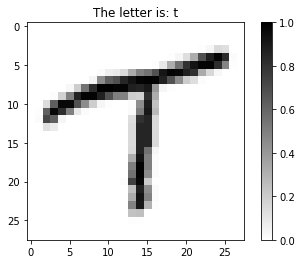

In [24]:
# Randomly show image from training dataset
img = show_data(train_x_letters, train_y_letters, digit = False)

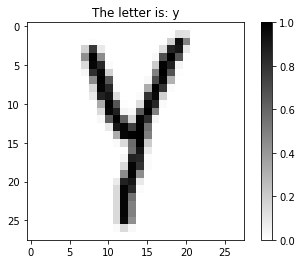

In [23]:
# Randomly show image from testing dataset
img = show_data(test_x_letters, test_y_letters, digit = False)


In [16]:
# Adjust shapes of data

# train set / data 
train_x_letters = np.expand_dims(train_x_letters, axis=-1)

# validation set / data 
test_x_letters = np.expand_dims(test_x_letters, axis=-1)

show_shapes(train_x_letters, train_y_letters, test_x_letters, test_y_letters, False)

Mnist  Alphabet  Dataset shapes: 
train X:  (124800, 28, 28, 1)
train Y:  (124800,)
test X:  (20800, 28, 28, 1)
test Y:  (20800,)


## **Mnist Digits**

In [17]:
# Load MNIST dataset using tensorflow

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

show_shapes(x_train, y_train, x_test, y_test)

# x_train.shape, y_train.shape: (60000, 28, 28) (60000,)
# x_test.shape,  y_test.shape : (10000, 28, 28) (10000,)

Mnist  Digit  Dataset shapes: 
train X:  (60000, 28, 28)
train Y:  (60000,)
test X:  (10000, 28, 28)
test Y:  (10000,)


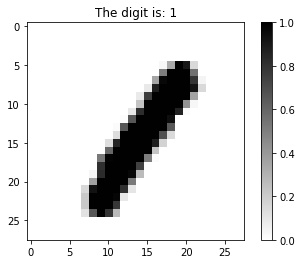

In [21]:
img = show_data(x_train, y_train)

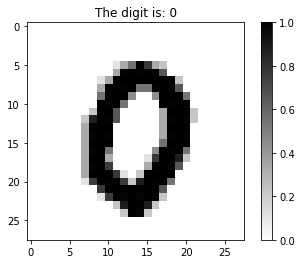

In [22]:
img = show_data(x_test, y_test)

In [20]:
# Adjust shapes of data

# train set / data 
x_train = np.expand_dims(x_train, axis=-1)

# validation set / data 
x_test = np.expand_dims(x_test, axis=-1)

show_shapes(x_train, y_train, x_test, y_test)

Mnist  Digit  Dataset shapes: 
train X:  (60000, 28, 28, 1)
train Y:  (60000,)
test X:  (10000, 28, 28, 1)
test Y:  (10000,)


# **Initialize model**

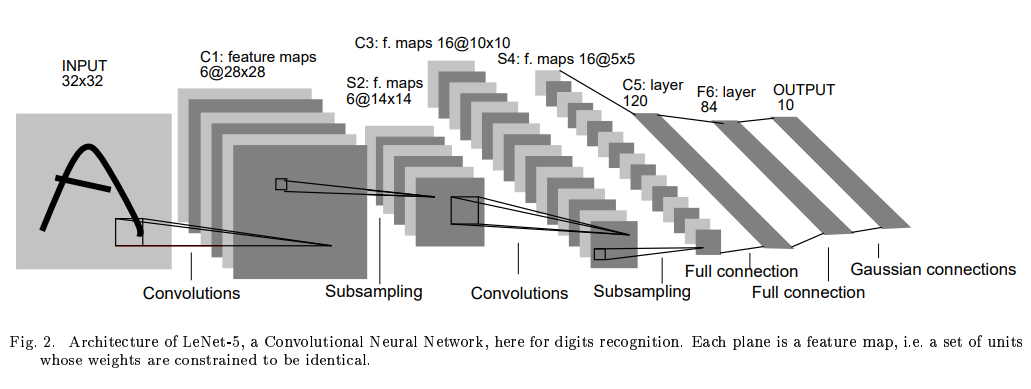

LeCun et al. (1998)

http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

In [25]:
from tensorflow.keras import Model, layers, Input, optimizers

In [22]:
# Create a LeNet 5 model class

class LeNetFive(Model):
    def __init__(self, num_classes, name=''):
        super(LeNetFive, self).__init__()
        self.modelName = name
        self.inputSz = (32, 32, 1)

        # define all layers in init

        #Preprocess
        self.reshapeInp = layers.Resizing(self.inputSz[0], self.inputSz[0], name='resize_input')

        # Input layer
        layers.InputLayer(input_shape=(self.inputSz), name='Input')

        # First Convolutional Layer
        self.conv1 = layers.Conv2D(filters=6, kernel_size=5, strides=1, activation='tanh', name='c1')
        self.avg_pool1  = layers.AveragePooling2D(pool_size=2, strides=2, name='s2')

        # Second Convolutional Layer
        self.conv2 = layers.Conv2D(filters=16, kernel_size=5, strides=1, activation='tanh', name='c3')
        self.avg_pool2  = layers.AveragePooling2D(pool_size=2, strides=2, name='s4')

        # Fully connected layers
        self.conv3 = layers.Conv2D(120, 5, activation='tanh', name='c5')
        self.flat = layers.Flatten(name='flat')
        self.dense1 = layers.Dense(84, activation='tanh', name='f6')
        self.dense2 = layers.Dense(num_classes, activation='softmax', name='output')


    def call(self, input_tensor, training=False):
        x = self.reshapeInp(input_tensor)

        # forward pass: First layer 
        x = self.conv1(x)
        x = self.avg_pool1(x)

        # forward pass: Second layer 
        x = self.conv2(x)
        x = self.avg_pool2(x)

        # Fully connected layers
        x = self.conv3(x)
        x = self.flat(x)
        x = self.dense1(x)
        return self.dense2(x)

    def leNetModel(self):
        # Model attributes to tf Model class

        self.inpTensor = Input(shape=(28,28,1), name='InputLayer')
        x1 = self.inpTensor
        return Model(inputs=[x1], outputs=self.call(x1), name=self.modelName)

## Instantiate and Train LesNet5 for Digit classification

In [23]:
# instantiate model object
model_digits = LeNetFive(10, 'LeNet_for_digits').leNetModel()

# print summary
model_digits.summary()

Model: "LeNet_for_digits"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 resize_input (Resizing)     (None, 32, 32, 1)         0         
                                                                 
 c1 (Conv2D)                 (None, 28, 28, 6)         156       
                                                                 
 s2 (AveragePooling2D)       (None, 14, 14, 6)         0         
                                                                 
 c3 (Conv2D)                 (None, 10, 10, 16)        2416      
                                                                 
 s4 (AveragePooling2D)       (None, 5, 5, 16)          0         
                                                                 
 c5 (Conv2D)                 (None, 1, 1, 120)    

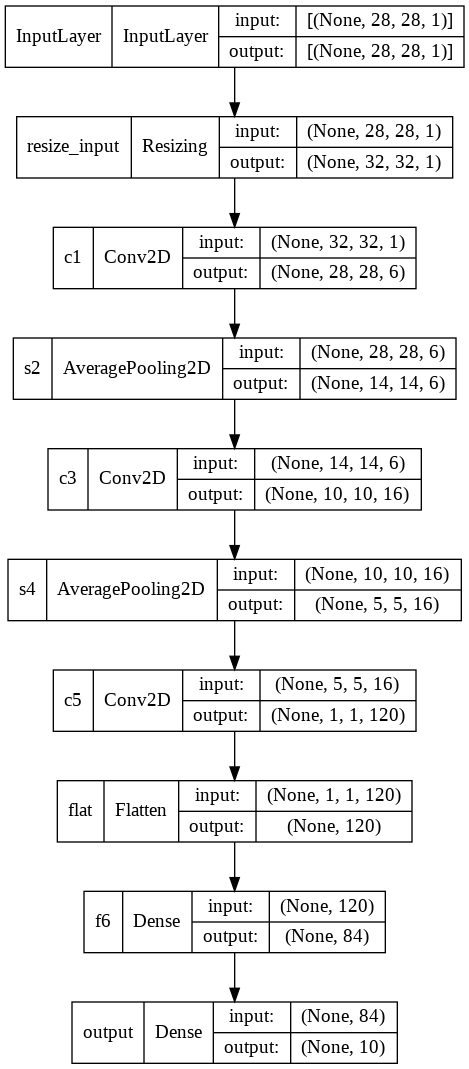

In [24]:
tf.keras.utils.plot_model(model_digits,show_shapes=True) 

In [ ]:
model_digits.compile(
    optimizer = 'SGD',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])

# fit 
history_digits = model_digits.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=20)
model_digits.evaluate(x_test, y_test)

### Model accuracy, model loss, and save model for LeNet5 for digit classification

In [ ]:
plot_accuracy(history_digits)

In [ ]:
plot_loss(history_digits)

In [ ]:
pd.DataFrame(history_digits.history).plot(figsize=(8,5))
plt.show()

In [ ]:
# To save the trained model
model_digits.save('model_digits.h5')

# To save the trained weights
model_digits.save_weights('model_digits_weights.h5')

## Instantiate and Train LesNet5 for Alphabet classification

In [ ]:
# instantiate model object
model_letters = LeNetFive(27, 'LeNet_for_Alphabets').leNetModel()

# print summary
model_letters.summary()

In [ ]:
tf.keras.utils.plot_model(model_letters,show_shapes=True)

In [ ]:
model_letters.compile(
    optimizer = 'SGD',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])
# fit 
history_letters = model_letters.fit(train_x_letters, train_y_letters, validation_data=(test_x_letters, test_y_letters), batch_size=32, epochs=20)
model_letters.evaluate(test_x_letters, test_y_letters)

### Model accuracy, model loss, and save model for LeNet5 for alphabet classification

In [ ]:
plot_accuracy(history_letters)

In [ ]:
plot_loss(history_letters)

In [ ]:
pd.DataFrame(history_letters.history).plot(figsize=(8,5))
plt.show()

In [ ]:
# To save the trained model
model_letters.save('letters_model.h5')

# To save the trained weights
model_letters.save_weights('letters_model_weights.h5')

# **Loading trained models**

In [26]:
# Location of the trained model
!git clone https://github.com/eliasezar27/LeNet5_implemetation.git

fatal: destination path 'LeNet5_implemetation' already exists and is not an empty directory.


In [27]:
model_dir = 'LeNet5_implemetation'

## LeNet5 for digits classification

In [29]:
# To load the trained model
new_model2 = tf.keras.models.load_model(os.path.join(model_dir, 'model_digits.h5')) 

# To load the trained weights to the model used
# digits_model.load_weights('model_digits_weights.h5')

new_model2.summary()

Model: "LeNet_for_digits"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 resize_input (Resizing)     (None, 32, 32, 1)         0         
                                                                 
 c1 (Conv2D)                 (None, 28, 28, 6)         156       
                                                                 
 s2 (AveragePooling2D)       (None, 14, 14, 6)         0         
                                                                 
 c3 (Conv2D)                 (None, 10, 10, 16)        2416      
                                                                 
 s4 (AveragePooling2D)       (None, 5, 5, 16)          0         
                                                                 
 c5 (Conv2D)                 (None, 1, 1, 120)    

In [30]:
new_model2.evaluate(x_test, y_test)

313/313 [==============================] - 3s 4ms/step - loss: 0.0338 - accuracy: 0.9879


[0.03379328176379204, 0.9879000186920166]

### Digit Prediction

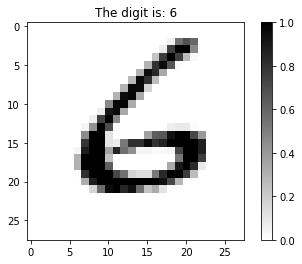



The predictied digit is 6 with a 0.9998116 probability


In [63]:
# Show digit image with true label in the title that returns a random image from the show_data function
test_img = show_data(x_test, y_test)
test_img = np.expand_dims(test_img, axis=0)

# Show predicted class of the random image
pred_arr = new_model2.predict(test_img)
print('\n\nThe predictied digit is', pred_arr.argmax(), 'with a', pred_arr.max(), 'probability')

## LeNet5 for alphabet classification

In [43]:
# To load the trained model
new_model = tf.keras.models.load_model(os.path.join(model_dir, 'letters_model.h5'))

# To load the trained weights to the model used
# letters_model.load_weights('letters_model_weights.h5')

new_model.summary()

Model: "LeNet_for_Alphabets"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 resize_input (Resizing)     (None, 32, 32, 1)         0         
                                                                 
 c1 (Conv2D)                 (None, 28, 28, 6)         156       
                                                                 
 s2 (AveragePooling2D)       (None, 14, 14, 6)         0         
                                                                 
 c3 (Conv2D)                 (None, 10, 10, 16)        2416      
                                                                 
 s4 (AveragePooling2D)       (None, 5, 5, 16)          0         
                                                                 
 c5 (Conv2D)                 (None, 1, 1, 120) 

In [44]:
new_model.evaluate(test_x_letters, test_y_letters)

650/650 [==============================] - 2s 4ms/step - loss: 0.2197 - accuracy: 0.9259


[0.21968473494052887, 0.9258654117584229]

### Alphabet Prediction

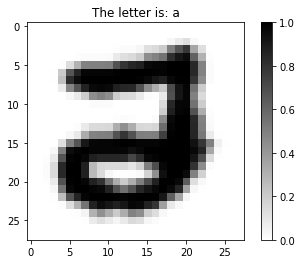



The predictied letter is a with a 0.75605917 probability


In [62]:
import string

# Show alphabet image with true label in the title that returns a random image from the show_data function
test_img = show_data(test_x_letters, test_y_letters, False)
test_img = np.expand_dims(test_img, axis=0)

# Show predicted class of the random image
pred_arr = new_model.predict(test_img)
print('\n\nThe predictied letter is', string.ascii_lowercase[pred_arr.argmax()-1], 'with a', pred_arr.max(), 'probability')